In [ ]:
! pip install youtube-dl
! conda config --add channels conda-forge
! conda install opencv

! wget http://crcv.ucf.edu/data/UCF11_updated_mpg.rar --no-check-certificate
! mkdir videos
! pushd videos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 7.3 MB/s 
/bin/bash: conda: command not found
/bin/bash: conda: command not found
--2022-07-12 16:59:32--  http://crcv.ucf.edu/data/UCF11_updated_mpg.rar
Resolving crcv.ucf.edu (crcv.ucf.edu)... 132.170.214.127
Connecting to crcv.ucf.edu (crcv.ucf.edu)|132.170.214.127|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.crcv.ucf.edu/data/UCF11_updated_mpg.rar [following]
--2022-07-12 16:59:33--  https://www.crcv.ucf.edu/data/UCF11_updated_mpg.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1045106394 (997M) [application/rar]
Saving to: ‘UCF11_updated_mpg.rar’

UCF11_updated_mpg.r 100%[=

In [ ]:
!unrar x "UCF11_updated_mpg.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from UCF11_updated_mpg.rar

Creating    UCF11_updated_mpg                                         OK
Creating    UCF11_updated_mpg/basketball                              OK
Creating    UCF11_updated_mpg/basketball/v_shooting_01                OK
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_01.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_02.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_03.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_04.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_05.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_06.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_07.mpg    

In [ ]:
import os
import sys
import argparse
import csv
import numpy as np
import imageio
imageio.plugins.ffmpeg.download()
from random import randint
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
def make_dataset(data_path, categories:list):

  group_list = []

  label = 0
  for label_folder in sorted(categories):
      label_folder_path = os.path.join(data_path, label_folder)
      if os.path.isdir(label_folder_path):
          group_folders = os.listdir(label_folder_path)
          for group_folder in group_folders:
              if group_folder != 'Annotation':
                  group_list.append([os.path.join(label_folder_path, group_folder), label])
          label += 1

  train_groups, test_groups = train_test_split(group_list, test_size=0.2)
  train_data = []
  test_data = []
  #print(len(train_groups))
  #print(len(test_groups))

  for i in range(0,len(train_groups)):
    group = train_groups[i]
    videos = os.listdir(group[0]) #group[0] = path
    for video in videos:
      video_path = os.path.join(group[0],video)
      if os.path.isfile(video_path):
        video_reader = imageio.get_reader(video_path, 'ffmpeg')
        if len(video_reader) >= 16:
            train_data.append([video_path, group[1]]) #group[1] = label


  for i in range(0,len(test_groups)):
    group = test_groups[i]
    videos = os.listdir(group[0]) #group[0] = path
    for video in videos:
      video_path = os.path.join(group[0],video)
      if os.path.isfile(video_path):
        video_reader = imageio.get_reader(video_path, 'ffmpeg')
        if len(video_reader) >= 16:
            test_data.append([video_path, group[1]]) #group[1] = label

  return train_data, test_data

def make_csv_file(items, file_path):

  with open(file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    writer.writerows(items)
  print("finished !")

In [ ]:
print(os.listdir("UCF11_updated_mpg"))

['basketball', 'soccer_juggling', 'volleyball_spiking', 'walking', 'trampoline_jumping', 'diving', 'horse_riding', 'tennis_swing', 'biking', 'golf_swing', 'swing']


In [ ]:
train, test = make_dataset("UCF11_updated_mpg",['biking','horse_riding'])
make_csv_file(train, ('train_map.csv'))
make_csv_file(test, ('test_map.csv'))

finished !


In [ ]:
import numpy
del train,test

In [ ]:
import tensorflow as tf
import numpy as np

def select_frames(video_file, sequence_length,width,height):
        try:
            video_reader = imageio.get_reader(video_file, 'ffmpeg')
            num_frames   = len(video_reader)
            if sequence_length > num_frames:
                raise ValueError('Sequence length is larger then total number of frames')

            step = 1
            expanded_sequence = sequence_length
            if num_frames > 2*sequence_length:
                step = 2
                expanded_sequence = 2*sequence_length

            seq_start = randint(0, num_frames - expanded_sequence)
            frame_range = [seq_start + step*i for i in range(sequence_length)]
            video_frames = []
            for frame_index in frame_range:
                video_frames.append(get_frame(video_reader.get_data(frame_index),width,height))

            return np.stack(video_frames, axis=0)

        except:
            print("Error reading video")

def get_frame(data,width,height):
        try:
            image = Image.fromarray(data)
            image.thumbnail((171, 128), Image.ANTIALIAS)
            center_w = image.size[0] / 2
            center_h = image.size[1] / 2

            image = image.crop((center_w - width  / 2,
                                center_h - height / 2,
                                center_w + width  / 2,
                                center_h + height / 2))

            norm_image = np.array(image, dtype=np.float32)
            norm_image /= 255

            return np.ascontiguousarray(np.transpose(norm_image, (1, 0, 2)))
        except:
            print("Error")

def read_video(csv_file, num_classes):
        size = 112
        num_frames = 16
        videos = []
        labels = []

        try:
            csv_file_dir = os.path.dirname(csv_file)
            with open(csv_file) as csv_file:
                data = csv.reader(csv_file)
                for row in data:
                    videos.append(os.path.join(csv_file_dir, row[0]))
                    one_hot_encoded_label = torch.nn.one_hot(torch.tensor([int(row[1])]), num_classes)
                    labels.append(one_hot_encoded_label.tolist()[0])

            vectored_videos = []
            for video_file in videos:
                vectored_video_file = select_frames(video_file, num_frames, size, size)
                vectored_videos.append(vectored_video_file)

            return np.array(vectored_videos),np.array(labels)
        except:
            print("error saving vector")

import numpy

num_output_classes = 2
train_reader = read_video('train_map.csv', num_output_classes)
test_reader  = read_video('test_map.csv', num_output_classes)
numpy.save('train_data.npy', train_reader[0])
numpy.save('train_label.npy', train_reader[1])
numpy.save('test_data.npy', test_reader[0])
numpy.save('test_label.npy', test_reader[1])

Error reading video


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
del train_reader, test_reader

In [ ]:
import numpy
train_d = numpy.load('train_data.npy',allow_pickle=True)
train_l = numpy.load('train_label.npy',allow_pickle=True)
test_d = numpy.load('test_data.npy',allow_pickle=True)
test_l = numpy.load('test_label.npy',allow_pickle=True)

print(train_d.shape)
print(train_l.shape)
print(test_d.shape)
print(test_l.shape)
print(train_d[0].shape)
print(type(train_d))

(261, 16, 112, 112, 3)
(261, 2)
(82, 16, 112, 112, 3)
(82, 2)
(16, 112, 112, 3)
<class 'numpy.ndarray'>


In [ ]:
from torch.utils.data import Dataset
import numpy as np
class CustomDataset(Dataset):
    def __init__(self,
                 data_path ='train_data.npy',
                 label_path ='train_label.npy'):

        self.data_path = data_path
        self.label_path = label_path
        self.dataset = self._read_data(self.data_path)
        self.labels =  self._read_data(self.label_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        imagelist = (numpy.array(self.dataset[index],dtype=np.float32))
        label = self.labels[index]
        return {
            'image': imagelist,
            'label': label
        }

    def _read_data(self, path):
        return np.load(path,allow_pickle=True)

    def delete_item(self,index):
        self.dataset = numpy.delete(self.dataset,index)
        self.labels =  numpy.delete(self.labels,index)

In [ ]:
import torch
import torch.nn as nn

train_dataset = CustomDataset(data_path ='train_data.npy',label_path ='train_label.npy')
test_dataset = CustomDataset(data_path ='test_data.npy',label_path ='test_label.npy')

In [ ]:
for i in range(0,len(train_dataset)):
  if(train_dataset[i]['image'].shape) != (16,112,112,3): print(i)

142


In [ ]:
for i in range(0,len(test_dataset)):
  if(test_dataset[i]['image'].shape) != (16,112,112,3): print(i)

In [ ]:
new_train_d = numpy.delete(train_d,142)
'''
new_test_d = numpy.delete(test_d,34)
new_test_d = numpy.delete(new_test_d,44)
new_test_d = numpy.delete(new_test_d,46)
print(new_test_d.shape)'''

#new_test_d = numpy.delete(test_d,46)
#del train_dataset, test_dataset, train_d #,test_d
del train_d
del train_dataset, test_dataset

In [ ]:
train_l = numpy.load('train_label.npy',allow_pickle=True)
test_l = numpy.load('test_label.npy',allow_pickle=True)
train_labels = []
test_labels = []

for i in range(0,len(train_l)):
  if (i != 142):
    train_labels.append(train_l[i])

for i in range(0,len(test_l)):
  #if i == 34 or i==44 or i==46: pass
  #else:
  test_labels.append(test_l[i])

print(len(test_labels))
print(len(train_labels))

del train_l, test_l

64
278


In [ ]:
print(new_train_d.shape)
print(numpy.array(train_labels).shape)
print(test_d.shape)
print(numpy.array(test_labels).shape)

(278,)
(278, 2)
(64, 16, 112, 112, 3)
(64, 2)


In [ ]:
for i in range(0,len(new_train_d)):
  if(new_train_d[i].shape) != (16, 112, 112, 3): print(i)

for i in range(0,len(test_d)):
  if(test_d[i].shape) != (16, 112, 112, 3): print(i)

In [ ]:
data = []

for a in range(len(new_train_d)):
  for b in range(16):
    for c in range(112):
      for d in range(112):
        for e in range(3):
          data.append(new_train_d[a][b][c][d][e])

x_train = np.array(data)
del data

In [ ]:
data = []

for a in range(len(test_d)):
  for b in range(16):
    for c in range(112):
      for d in range(112):
        for e in range(3):
          data.append(test_d[a][b][c][d][e])

x_test = np.array(data)
del data

In [ ]:
print(x_train.shape)
x_train = x_train.reshape(-1,16,112,112,3)
print(*x_train.shape)
print(x_test.shape)
x_test = x_test.reshape(-1,16,112,112,3)
print(*x_test.shape)

(278, 16, 112, 112, 3)
278 16 112 112 3
(64, 16, 112, 112, 3)
64 16 112 112 3


In [ ]:
del train_d,test_d

In [ ]:
import numpy as np
from tensorflow import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 64, padding='same',
                     kernel_size = (3, 3), return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(ConvLSTM2D(filters = 64, padding='same',
                     kernel_size = (3, 3), return_sequences = False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation = "softmax"))
model.summary()
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 25, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_14 (ConvLSTM2D)  (None, 16, 112, 112, 64)  154624   
                                                                 
 dropout_7 (Dropout)         (None, 16, 112, 112, 64)  0         
                                                                 
 batch_normalization_14 (Bat  (None, 16, 112, 112, 64)  256      
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 56, 56, 64)    0         
 3D)                                                             
                                                                 
 conv_lstm2d_15 (ConvLSTM2D)  (None, 56, 56, 64)       295168    
                                                                 
 dropout_8 (Dropout)         (None, 56, 56, 64)       

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 16, padding='same',
                     kernel_size = (3, 3), return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))
model.summary()
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 30, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_23 (ConvLSTM2D)  (None, 16, 112, 112, 16)  11008    
                                                                 
 dropout_22 (Dropout)        (None, 16, 112, 112, 16)  0         
                                                                 
 batch_normalization_23 (Bat  (None, 16, 112, 112, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 8, 56, 56, 16)    0         
 g3D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 401408)            0         
                                                                 
 dense_29 (Dense)            (None, 16)              

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 8, padding='same',
                     kernel_size = (3, 3), return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))
model.summary()
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_26 (ConvLSTM2D)  (None, 16, 112, 112, 8)  3200      
                                                                 
 dropout_26 (Dropout)        (None, 16, 112, 112, 8)   0         
                                                                 
 batch_normalization_26 (Bat  (None, 16, 112, 112, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 56, 56, 8)     0         
 g3D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 200704)            0         
                                                                 
 dense_35 (Dense)            (None, 16)              

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 8, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(2, activation = "softmax"))
model.summary()
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_37 (ConvLSTM2D)  (None, 16, 112, 112, 8)  3200      
                                                                 
 dropout_44 (Dropout)        (None, 16, 112, 112, 8)   0         
                                                                 
 batch_normalization_35 (Bat  (None, 16, 112, 112, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 8, 56, 56, 8)     0         
 g3D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 200704)            0         
                                                                 
 dense_53 (Dense)            (None, 8)               

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 32, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(2, activation = "softmax"))
model.summary()
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_43 (ConvLSTM2D)  (None, 16, 112, 112, 32)  40448    
                                                                 
 dropout_50 (Dropout)        (None, 16, 112, 112, 32)  0         
                                                                 
 batch_normalization_41 (Bat  (None, 16, 112, 112, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 8, 56, 56, 32)    0         
 g3D)                                                            
                                                                 
 flatten_29 (Flatten)        (None, 802816)            0         
                                                                 
 dense_64 (Dense)            (None, 8)               

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_48 (ConvLSTM2D)  (None, 16, 112, 112, 16)  11008    
                                                                 
 dropout_55 (Dropout)        (None, 16, 112, 112, 16)  0         
                                                                 
 batch_normalization_46 (Bat  (None, 16, 112, 112, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_35 (MaxPoolin  (None, 8, 56, 56, 16)    0         
 g3D)                                                            
                                                                 
 conv_lstm2d_49 (ConvLSTM2D)  (None, 56, 56, 16)       18496     
                                                                 
 dropout_56 (Dropout)        (None, 56, 56, 16)      

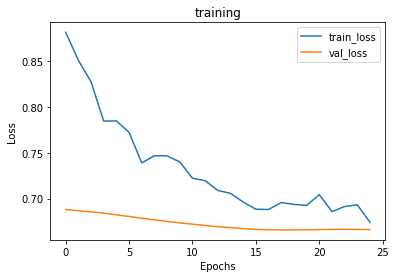

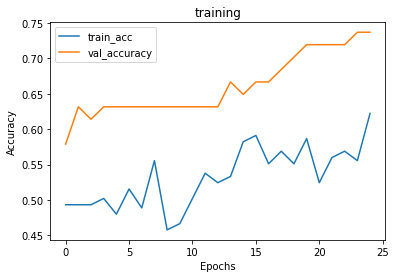

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 16, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(ConvLSTM2D(filters = 16, padding='same',kernel_size = (3, 3), return_sequences = False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(2, activation = "softmax"))
model.summary()
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)


import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
time = np.arange(len(train_loss))

plt.plot(time, train_loss,label='train_loss')
plt.plot(time, val_loss,  label='val_loss')

plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


plt.plot(time, train_acc,label='train_acc')
plt.plot(time, val_acc,  label='val_accuracy')

plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 32, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(ConvLSTM2D(filters = 32, padding='same',kernel_size = (3, 3), return_sequences = False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(2, activation = "softmax"))
model.summary()
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_52 (ConvLSTM2D)  (None, 16, 112, 112, 32)  40448    
                                                                 
 dropout_59 (Dropout)        (None, 16, 112, 112, 32)  0         
                                                                 
 batch_normalization_50 (Bat  (None, 16, 112, 112, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 8, 56, 56, 32)    0         
 g3D)                                                            
                                                                 
 conv_lstm2d_53 (ConvLSTM2D)  (None, 56, 56, 32)       73856     
                                                                 
 dropout_60 (Dropout)        (None, 56, 56, 32)      

Epoch 1/60
29/29 [==============================] - 40s 480ms/step - loss: 0.7360 - accuracy: 0.5111 - val_loss: 0.6916 - val_accuracy: 0.5263
Epoch 2/60
29/29 [==============================] - 14s 490ms/step - loss: 0.7143 - accuracy: 0.5244 - val_loss: 0.6953 - val_accuracy: 0.4737
Epoch 3/60
29/29 [==============================] - 14s 468ms/step - loss: 0.7063 - accuracy: 0.5111 - val_loss: 0.7019 - val_accuracy: 0.4737
Epoch 4/60
29/29 [==============================] - 13s 464ms/step - loss: 0.6914 - accuracy: 0.5467 - val_loss: 0.7103 - val_accuracy: 0.4737
Epoch 5/60
29/29 [==============================] - 13s 464ms/step - loss: 0.6785 - accuracy: 0.5778 - val_loss: 0.7180 - val_accuracy: 0.4737
Epoch 6/60
29/29 [==============================] - 13s 462ms/step - loss: 0.6794 - accuracy: 0.5778 - val_loss: 0.7259 - val_accuracy: 0.4737
Epoch 7/60
29/29 [==============================] - 13s 463ms/step - loss: 0.6755 - accuracy: 0.5822 - val_loss: 0.7330 - val_accuracy: 0.4737

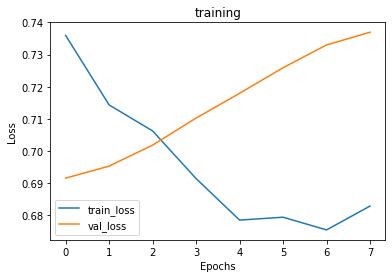

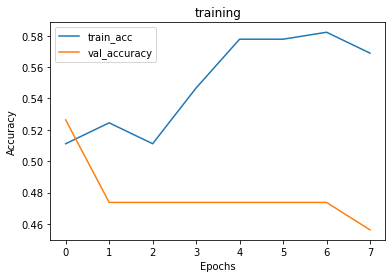

In [ ]:
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),callbacks=callbacks)


import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
time = np.arange(len(train_loss))

plt.plot(time, train_loss,label='train_loss')
plt.plot(time, val_loss,  label='val_loss')

plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(time, train_acc,label='train_acc')
plt.plot(time, val_acc,  label='val_accuracy')
plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 8, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(ConvLSTM2D(filters = 8, padding='same',kernel_size = (3, 3), return_sequences = False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))
model.summary()
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_58 (ConvLSTM2D)  (None, 16, 112, 112, 8)  3200      
                                                                 
 dropout_65 (Dropout)        (None, 16, 112, 112, 8)   0         
                                                                 
 batch_normalization_56 (Bat  (None, 16, 112, 112, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 8, 56, 56, 8)     0         
 g3D)                                                            
                                                                 
 conv_lstm2d_59 (ConvLSTM2D)  (None, 56, 56, 8)        4640      
                                                                 
 dropout_66 (Dropout)        (None, 56, 56, 8)       

Epoch 1/60
57/57 [==============================] - 11s 196ms/step - loss: 0.8116 - accuracy: 0.4800 - val_loss: 0.7119 - val_accuracy: 0.4211
Epoch 2/60
57/57 [==============================] - 11s 192ms/step - loss: 0.8082 - accuracy: 0.4933 - val_loss: 0.7165 - val_accuracy: 0.4035
Epoch 3/60
57/57 [==============================] - 11s 195ms/step - loss: 0.8169 - accuracy: 0.5156 - val_loss: 0.7202 - val_accuracy: 0.4035
Epoch 4/60
57/57 [==============================] - 12s 213ms/step - loss: 0.7910 - accuracy: 0.4844 - val_loss: 0.7225 - val_accuracy: 0.4035
Epoch 5/60
57/57 [==============================] - 11s 194ms/step - loss: 0.7647 - accuracy: 0.4667 - val_loss: 0.7241 - val_accuracy: 0.4035
Epoch 6/60
57/57 [==============================] - 11s 196ms/step - loss: 0.7418 - accuracy: 0.5111 - val_loss: 0.7253 - val_accuracy: 0.4211
Epoch 7/60
57/57 [==============================] - 11s 193ms/step - loss: 0.7447 - accuracy: 0.4844 - val_loss: 0.7257 - val_accuracy: 0.4211

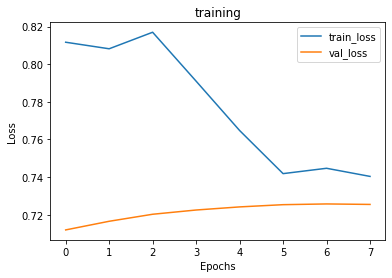

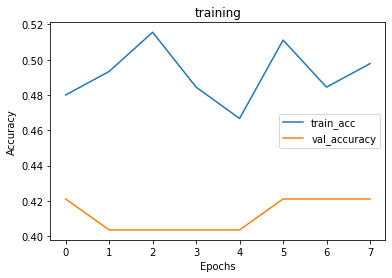

In [ ]:
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]

history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 4 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),callbacks=callbacks)


import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
time = np.arange(len(train_loss))

plt.plot(time, train_loss,label='train_loss')
plt.plot(time, val_loss,  label='val_loss')

plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(time, train_acc,label='train_acc')
plt.plot(time, val_acc,  label='val_accuracy')
plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 4, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(1,2,2)))
model.add(ConvLSTM2D(filters = 2, padding='same',kernel_size = (3, 3),
                     return_sequences = False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(1,3)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(2, activation = "softmax"))
model.summary()
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_69 (ConvLSTM2D)  (None, 16, 112, 112, 4)  1024      
                                                                 
 dropout_78 (Dropout)        (None, 16, 112, 112, 4)   0         
                                                                 
 batch_normalization_67 (Bat  (None, 16, 112, 112, 4)  16        
 chNormalization)                                                
                                                                 
 max_pooling3d_50 (MaxPoolin  (None, 16, 56, 56, 4)    0         
 g3D)                                                            
                                                                 
 conv_lstm2d_70 (ConvLSTM2D)  (None, 56, 56, 2)        440       
                                                                 
 dropout_79 (Dropout)        (None, 56, 56, 2)       

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_74 (ConvLSTM2D)  (None, 16, 112, 112, 6)  1968      
                                                                 
 dropout_83 (Dropout)        (None, 16, 112, 112, 6)   0         
                                                                 
 batch_normalization_72 (Bat  (None, 16, 112, 112, 6)  24        
 chNormalization)                                                
                                                                 
 max_pooling3d_54 (MaxPoolin  (None, 8, 56, 56, 6)     0         
 g3D)                                                            
                                                                 
 flatten_47 (Flatten)        (None, 150528)            0         
                                                                 
 dense_99 (Dense)            (None, 6)               

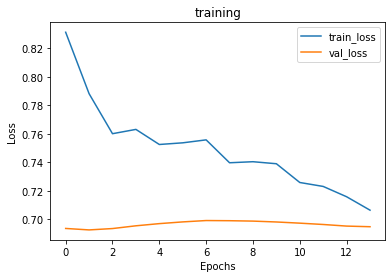

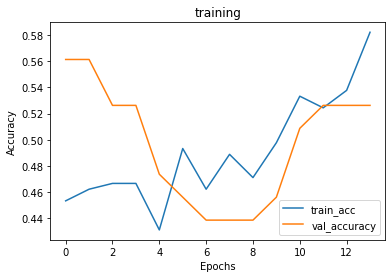

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 6, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dense(6, activation="relu"))
model.add(Dense(2, activation = "softmax"))
model.summary()
earlystop = EarlyStopping(patience=12)
callbacks = [earlystop]

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.0000001),metrics=['accuracy'])

history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)

import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
time = np.arange(len(train_loss))

plt.plot(time, train_loss,label='train_loss')
plt.plot(time, val_loss,  label='val_loss')

plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(time, train_acc,label='train_acc')
plt.plot(time, val_acc,  label='val_accuracy')
plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Epoch 1/50
29/29 [==============================] - 7s 152ms/step - loss: 0.7125 - accuracy: 0.5531 - val_loss: 0.6909 - val_accuracy: 0.5536
Epoch 2/50
29/29 [==============================] - 4s 130ms/step - loss: 0.7026 - accuracy: 0.5619 - val_loss: 0.6899 - val_accuracy: 0.6071
Epoch 3/50
29/29 [==============================] - 4s 128ms/step - loss: 0.6880 - accuracy: 0.5973 - val_loss: 0.6891 - val_accuracy: 0.6429
Epoch 4/50
29/29 [==============================] - 4s 130ms/step - loss: 0.6752 - accuracy: 0.6239 - val_loss: 0.6881 - val_accuracy: 0.6964
Epoch 5/50
29/29 [==============================] - 4s 133ms/step - loss: 0.6673 - accuracy: 0.6681 - val_loss: 0.6871 - val_accuracy: 0.6250
Epoch 6/50
29/29 [==============================] - 4s 133ms/step - loss: 0.6547 - accuracy: 0.6770 - val_loss: 0.6857 - val_accuracy: 0.6607
Epoch 7/50
29/29 [==============================] - 4s 134ms/step - loss: 0.6491 - accuracy: 0.7035 - val_loss: 0.6842 - val_accuracy: 0.6429
Epoch 

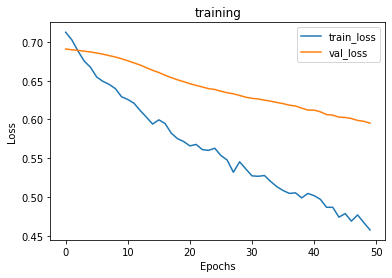

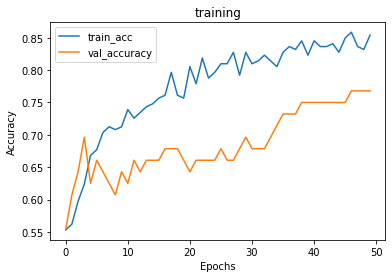

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 2, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dense(4, activation="relu"))
model.add(Dense(2, activation = "softmax"))
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 50, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)


import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
time = np.arange(len(train_loss))

plt.plot(time, train_loss,label='train_loss')
plt.plot(time, val_loss,  label='val_loss')

plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(time, train_acc,label='train_acc')
plt.plot(time, val_acc,  label='val_accuracy')
plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Epoch 1/60
57/57 [==============================] - 11s 148ms/step - loss: 0.7090 - accuracy: 0.5664 - val_loss: 0.6860 - val_accuracy: 0.5000
Epoch 2/60
57/57 [==============================] - 8s 137ms/step - loss: 0.6596 - accuracy: 0.6460 - val_loss: 0.6837 - val_accuracy: 0.5714
Epoch 3/60
57/57 [==============================] - 9s 156ms/step - loss: 0.6518 - accuracy: 0.6239 - val_loss: 0.6827 - val_accuracy: 0.6071
Epoch 4/60
57/57 [==============================] - 8s 139ms/step - loss: 0.6416 - accuracy: 0.6327 - val_loss: 0.6805 - val_accuracy: 0.6071
Epoch 5/60
57/57 [==============================] - 8s 138ms/step - loss: 0.6308 - accuracy: 0.6637 - val_loss: 0.6767 - val_accuracy: 0.6071
Epoch 6/60
57/57 [==============================] - 8s 139ms/step - loss: 0.6259 - accuracy: 0.6637 - val_loss: 0.6728 - val_accuracy: 0.6071
Epoch 7/60
57/57 [==============================] - 8s 138ms/step - loss: 0.6184 - accuracy: 0.6460 - val_loss: 0.6666 - val_accuracy: 0.6250
Epoch

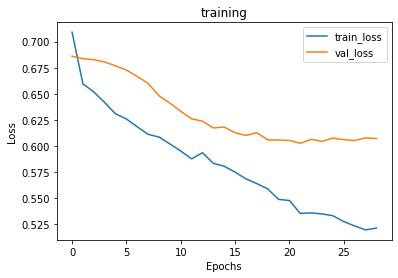

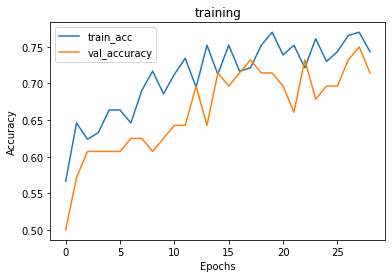

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 6, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dense(4, activation="relu"))
model.add(Dense(2, activation = "softmax"))
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 4 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)

import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
time = np.arange(len(train_loss))

plt.plot(time, train_loss,label='train_loss')
plt.plot(time, val_loss,  label='val_loss')

plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(time, train_acc,label='train_acc')
plt.plot(time, val_acc,  label='val_accuracy')

plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Epoch 1/60
57/57 [==============================] - 11s 146ms/step - loss: 0.7068 - accuracy: 0.4425 - val_loss: 0.6902 - val_accuracy: 0.5357
Epoch 2/60
57/57 [==============================] - 8s 141ms/step - loss: 0.6910 - accuracy: 0.4823 - val_loss: 0.6903 - val_accuracy: 0.6250
Epoch 3/60
57/57 [==============================] - 8s 139ms/step - loss: 0.6903 - accuracy: 0.5088 - val_loss: 0.6907 - val_accuracy: 0.6071
Epoch 4/60
57/57 [==============================] - 8s 140ms/step - loss: 0.6891 - accuracy: 0.5044 - val_loss: 0.6917 - val_accuracy: 0.5893
Epoch 5/60
57/57 [==============================] - 8s 141ms/step - loss: 0.6861 - accuracy: 0.5177 - val_loss: 0.6930 - val_accuracy: 0.5714
Epoch 6/60
57/57 [==============================] - 8s 140ms/step - loss: 0.6836 - accuracy: 0.5265 - val_loss: 0.6925 - val_accuracy: 0.5357
Epoch 7/60
57/57 [==============================] - 8s 141ms/step - loss: 0.6845 - accuracy: 0.6460 - val_loss: 0.6928 - val_accuracy: 0.5357
Epoch

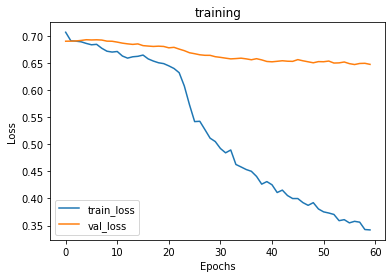

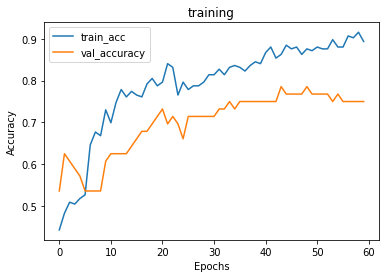

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 6, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dense(4, activation="relu"))
model.add(Dense(2, activation = "softmax"))
earlystop = EarlyStopping(patience=20)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 4 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)


import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
time = np.arange(len(train_loss))

plt.plot(time, train_loss,label='train_loss')
plt.plot(time, val_loss,  label='val_loss')
plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(time, train_acc,label='train_acc')
plt.plot(time, val_acc,  label='val_accuracy')
plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Epoch 1/60
29/29 [==============================] - 11s 227ms/step - loss: 0.7256 - accuracy: 0.5442 - val_loss: 0.6938 - val_accuracy: 0.4643
Epoch 2/60
29/29 [==============================] - 6s 210ms/step - loss: 0.7037 - accuracy: 0.5088 - val_loss: 0.6941 - val_accuracy: 0.4821
Epoch 3/60
29/29 [==============================] - 6s 210ms/step - loss: 0.7131 - accuracy: 0.5619 - val_loss: 0.6945 - val_accuracy: 0.4464
Epoch 4/60
29/29 [==============================] - 6s 209ms/step - loss: 0.7508 - accuracy: 0.4735 - val_loss: 0.6950 - val_accuracy: 0.4286
Epoch 5/60
29/29 [==============================] - 6s 210ms/step - loss: 0.7356 - accuracy: 0.5044 - val_loss: 0.6953 - val_accuracy: 0.4286
Epoch 6/60
29/29 [==============================] - 6s 210ms/step - loss: 0.7160 - accuracy: 0.5708 - val_loss: 0.6952 - val_accuracy: 0.4464
Epoch 7/60
29/29 [==============================] - 6s 210ms/step - loss: 0.7352 - accuracy: 0.4956 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch

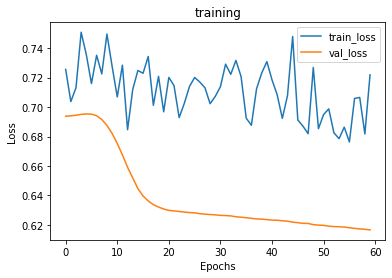

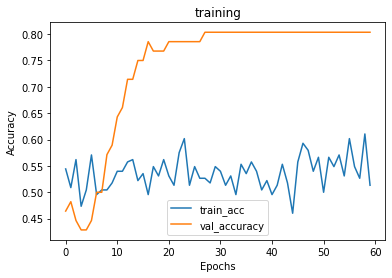

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 6, padding='same',kernel_size = (3, 3),
                     return_sequences = True, data_format = "channels_last", input_shape = (16, 112, 112, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool3D(pool_size=(2,2,2)))
model.add(ConvLSTM2D(filters = 1, padding='same',kernel_size = (3, 3),
                     return_sequences = False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(4, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation = "softmax"))
earlystop = EarlyStopping(patience=20)
callbacks = [earlystop]
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x = x_train, y = np.array(train_labels),
                    epochs = 60, batch_size = 8 ,
                    shuffle=True, validation_data = (x_test,np.array(test_labels)),
                    callbacks=callbacks)


import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
time = np.arange(len(train_loss))

plt.plot(time, train_loss,label='train_loss')
plt.plot(time, val_loss,  label='val_loss')

plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(time, train_acc,label='train_acc')
plt.plot(time, val_acc,  label='val_accuracy')
plt.legend()
plt.title('training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset ,batch_size = 8, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset ,batch_size = 8 , shuffle=False)

In [ ]:
import torch
import torch.nn as nn

# Original ConvLSTM cell as proposed by Shi et al.
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels,
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "relu":
            self.activation = torch.relu

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels,
            out_channels=4 * out_channels,
            kernel_size=kernel_size,
            padding=padding)

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C


In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels,
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels,
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = 8,0,16,112,112  #X.size()
        #8,0,16,112,112    #

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len,
        height, width, device=device)

        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels,
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels,
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [ ]:
import torch.nn as nn
import torch

class model(nn.Module):

    def __init__(self, num_channels, num_kernels:list, kernel_size, padding,
    activation, frame_size, num_layers):

        super(model, self).__init__()

        self.sequential = nn.Sequential()

        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels[0],
                kernel_size=kernel_size, padding=padding,
                activation=activation, frame_size=frame_size)
        )
        self.sequential.add_module('Dropout1',nn.Dropout(p = 0.5))

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels[0])
        )

        self.sequential.add_module("max_pooling3d1",nn.MaxPool3d((2,2,2)))

        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels[l-2], out_channels=num_kernels[l-1],
                    kernel_size=kernel_size, padding=padding,
                    activation=activation, frame_size=frame_size)
                )
            self.sequential.add_module(f"Dropout{l}",nn.Dropout(p = 0.5))

            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels[l-1])
                )

        self.sequential.add_module("flatten",nn.Flatten())
        self.sequential.add_module("linear1",nn.Linear(56*56*num_kernels[-1],8))
        self.sequential.add_module("relu",nn.ReLU())
        self.sequential.add_module("linear2",nn.Linear(8,2))

    def forward(self, X):
        output = self.sequential(X)
        return output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You are using {device}!")

You are using cuda!


In [ ]:
model = model(num_channels=3, num_kernels=[8,8],
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(112, 112), num_layers=2).to(device)

Epoch:0 Training Loss:0.79  Validation Loss:0.78  Accuracy:46.43

Epoch:1 Training Loss:0.78  Validation Loss:0.78  Accuracy:48.21

Epoch:2 Training Loss:0.76  Validation Loss:0.75  Accuracy:49.64

Epoch:3 Training Loss:0.75  Validation Loss:0.74  Accuracy:51.86

Epoch:4 Training Loss:0.77  Validation Loss:0.76  Accuracy:38.90

Epoch:5 Training Loss:0.76  Validation Loss:0.75  Accuracy:43.21

Epoch:6 Training Loss:0.76  Validation Loss:0.74  Accuracy:46.87

Epoch:7 Training Loss:0.75  Validation Loss:0.73  Accuracy:48.98

Epoch:8 Training Loss:0.75  Validation Loss:0.74  Accuracy:53.21

Epoch:9 Training Loss:0.75  Validation Loss:0.72  Accuracy:56.12

Epoch:10 Training Loss:0.74  Validation Loss:0.73  Accuracy:54.23

Epoch:11 Training Loss:0.74  Validation Loss:0.73  Accuracy:55.45

Epoch:12 Training Loss:0.74  Validation Loss:0.73  Accuracy:54.76

Epoch:13 Training Loss:0.73  Validation Loss:0.72  Accuracy:62.32

Epoch:14 Training Loss:0.73  Validation Loss:0.71  Accuracy:65.43

Epoch

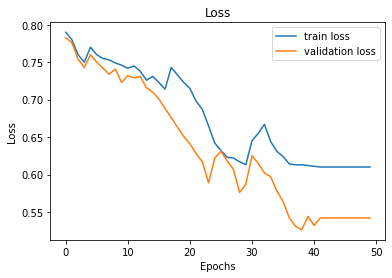

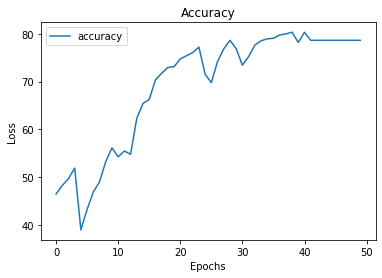

In [ ]:
num_epochs = 50
criterion = nn.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.000001)
n_train_batches = len(train_loader)
n_test_batches = len(test_loader)
train_loss_list = []
test_loss_list = []
acc_list = []
for epoch in range(1, num_epochs+1):
  train_loss, test_loss = 0.0, 0.0
  for (batch_idx , batch) in enumerate(train_loader):
      #getting data
      frames = batch['image'].to(device)
      labels = batch['label'].to(device)
      #forward propagation
      output = model(frames)
      loss = criterion(output,labels)
      train_loss += loss
      #backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  with torch.no_grad():
      total = 0
      correct = 0
      s = nn.Softmax(dim=1)
      for (batch_index, content) in enumerate(test_loader):
          images = content['image'].to(device)
          labels = content['label'].to(device)
          out = model(images)
          loss2 = criterion(out,labels)
          test_loss += loss2
          out = s(out)
          _,predicted = torch.max(out.data,1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  real_train_loss = train_loss/n_train_batches
  real_test_loss = test_loss/n_test_batches
  real_acc = 100*correct/total
  train_loss_list.append(real_train_loss)
  test_loss_list.append(real_test_loss)
  acc_list.append(real_acc)
  print("Epoch:{} Training Loss:{:.2f}  Validation Loss:{:.2f}  Accuracy:{:.2f}\n".format(
      i, real_train_loss, real_test_loss, real_acc))


import matplotlib.pyplot as plt
import numpy as np

time = np.arange(num_epochs)
plt.plot(time, train_loss_list,label='train loss')
plt.plot(time, test_loss_list, label='validation loss')

plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(time, acc_list, label='accuracy')

plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()